# Geodatenhandling 1

**Inhalt:** Etwas mehr als nur erste Schritte mit Geopandas

**Nötige Skills**
- Basic pandas skills
- Funktionen und pandas
- Erste Schritte mit Geopandas

**Lernziele**
- Koordinatensysteme kennenlernen
- Koordinaten transformieren
- Spatial Joins
- Choropleth maps

## Das Beispiel

Coop-Läden in der Schweiz.
- Liste "gescrapt" von hier: https://www.coop.ch/de/services/standorte-und-oeffnungszeiten.html
- Siehe File `Coop.ipynb`

Wir wollen diese Läden auf einer Karte als Punkte darstellen und wollen ausserdem auswerten, in welchen Kantonen es wieviele Läden gibt!

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
%matplotlib inline

## Import

**Wir verwenden wiederum ein Shapefile der Kantone**

In [2]:
gdf_kantone = gpd.read_file('dataprojects/Projections/shp/g1k17.shp')

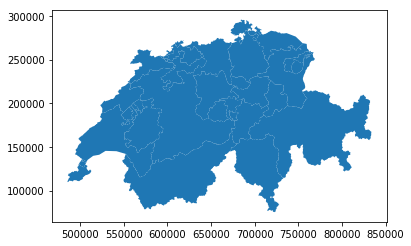

In [3]:
gdf_kantone.plot()

**Liste der Coop-Läden**

In [4]:
df_stores = pd.read_csv('dataprojects/Coop/geschaefte.csv')

In [5]:
df_stores.head()

,hausnummer,latitude,longitude,name,ort,plz,strasse,typ
0,42,46.837574,8.186167,coop-supermarkt-giswil,Giswil,6074,Brünigstrasse,retail
1,2,46.728708,8.181781,coop-supermarkt-meiringen,Meiringen,3860,Alpwegern,retail
2,32,46.897303,8.251211,coop-supermarkt-sarnen,Sarnen,6060,Marktstrasse,retail
3,32,46.897303,8.251211,coop-restaurant-sarnen,Sarnen,6060,Marktstrasse,restaurant
4,5,46.820871,8.404397,coop-supermarkt-engelberg,Engelberg,6390,Titliszentrum,retail


In [6]:
df_stores['typ'].value_counts()

retail        923
pronto        318
id            183
restaurant    155
impo          119
vitality       78
bh             73
christ         66
city           31
livique        24
lumimart       18
togo           18
takeit         15
marche         13
hotel          10
capuccini       8
burger          5
toptip          4
sapori          3
cindy           3
zopf            3
karma           2
halba           2
perpiedi        1
Name: typ, dtype: int64

## Geometrie

Wir müssen aus unserer Liste wiederum ein GeoDataFrame erstellen.

Die Schritte dazu sind:
- Identifizieren, welche Spalte die geografischen Infos enthält
- Geometrie-Spalte im Dataframe erstellen
- Aus Dataframe ein GeoDataFrame machen

**Spalte identifizieren**

In [84]:
df_stores.columns

Index(['hausnummer', 'latitude', 'longitude', 'name', 'ort', 'plz', 'strasse',
       'typ', 'Punkt'],
      dtype='object')

Mehr Infos zum geodetic system: https://gps-coordinates.org/

**Geometrie erstellen**

In [7]:
df_stores['Punkt'] = df_stores.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [8]:
df_stores.head(2)

,hausnummer,latitude,longitude,name,ort,plz,strasse,typ,Punkt
0,42,46.837574,8.186167,coop-supermarkt-giswil,Giswil,6074,Brünigstrasse,retail,POINT (8.186166999999999 46.837574)
1,2,46.728708,8.181781,coop-supermarkt-meiringen,Meiringen,3860,Alpwegern,retail,POINT (8.181780999999999 46.728708)


**Geodataframe kreieren**

In [9]:
gdf_stores = gpd.GeoDataFrame(df_stores, geometry='Punkt')

In [10]:
gdf_stores.head(2)

,hausnummer,latitude,longitude,name,ort,plz,strasse,typ,Punkt
0,42,46.837574,8.186167,coop-supermarkt-giswil,Giswil,6074,Brünigstrasse,retail,POINT (8.186166999999999 46.837574)
1,2,46.728708,8.181781,coop-supermarkt-meiringen,Meiringen,3860,Alpwegern,retail,POINT (8.181780999999999 46.728708)


Hat es funktioniert?

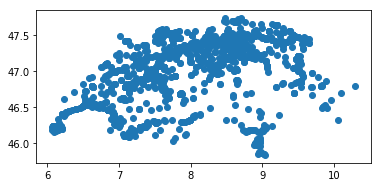

In [11]:
gdf_stores.plot()

## Koordinaten transformieren

Machen wir nun dasselbe wie im vorherigen Notebook: Plotten wir die Coop-Standorte auf die Schweizer Karte!

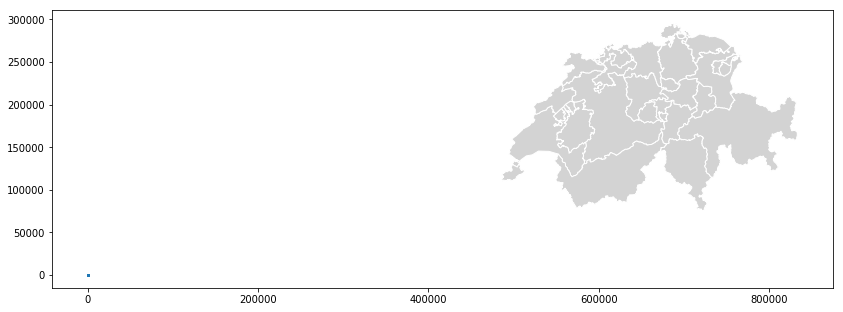

In [12]:
ax = gdf_kantone.plot(figsize=(14,10), color='lightgrey', edgecolor='white')
gdf_stores.plot(markersize=3, ax=ax)

Das Problem ist: die beiden Geodataframes verwenden verschiedene Koordinatensysteme!

Das Koordinatensystem in Geodataframes ist in der Property `crs` gespeichert.

**Kantone: Schweizer Koordinatensystem**
siehe: https://de.wikipedia.org/wiki/Schweizer_Landeskoordinaten

In [13]:
gdf_kantone.crs

{'ellps': 'bessel',
 'k_0': 1,
 'lat_0': 46.95240555555556,
 'lon_0': 7.439583333333333,
 'no_defs': True,
 'proj': 'somerc',
 'units': 'm',
 'x_0': 600000,
 'y_0': 200000}

**Geschäfte: Haben noch keines!**

In [14]:
gdf_stores.crs

Allerdings wissen wir, dass die Koordinaten im world geodetic system kodiert sind. Um dies Geopandas mitzuteilen, müssen wir das Geodataframe mit einem bestimmten Code initiatilisieren:

In [15]:
gdf_stores.crs = {'init': 'epsg:4326'}

In [16]:
gdf_stores.crs

{'init': 'epsg:4326'}

**EPSG-Codes**

EPSG steht für European Petroleum Survey Group:
- https://epsg.io/

Jedes Koordinatensystem hat eine Nummer
- https://de.wikipedia.org/wiki/European_Petroleum_Survey_Group_Geodesy#EPSG-Codes

Ein paar gängige Nummern

| Code | Description |
|------|---------------------------|
| 4326 | #world geodetic system |
| 3857 | #mercator |
| 2163 | #nice aea projection for the USA |
| 5071 | #another good one for the USA |
| 3395 | #mercator (anotherone) |
| 21781 | #swiss coordinate system |

Wir wollen das Schweizer Koordinatensystem verwenden. Um die Koordinaten zu transformieren, verwenden wir `to_crs()`:

In [17]:
gdf_stores = gdf_stores.to_crs(epsg=21781)

Jetzt sind beide Geodataframes im selben Koordinatensystem kodiert und wir können sie auf einer Karte plotten

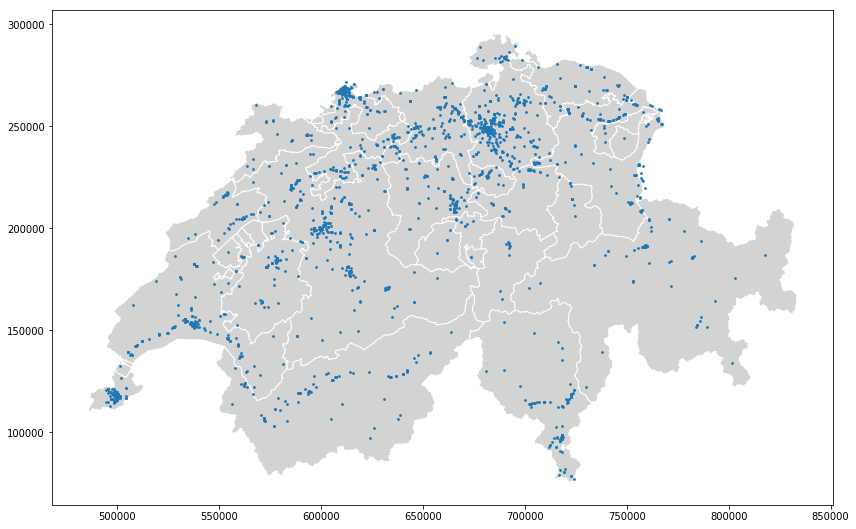

In [18]:
ax = gdf_kantone.plot(figsize=(14,10), color='lightgrey', edgecolor='white')
gdf_stores.plot(markersize=3, ax=ax)

**Zusatzaufgabe:** Plotten Sie die verschiedenen Geschäftstypen je in eigenen Farben!

In [38]:
colors = {
    'retail': 'blue',
    'pronto': 'green',
    'id': 'orange',
    'restaurant': 'red',
    'impo': 'darkblue',
    'vitality': 'darkgreen',
    'bh': 'black',
    'christ': 'black',
    'city': 'black',
    'livique': 'black',
    'togo': 'black',
    'lumimart': 'black',
    'takeit': 'black',
    'marche': 'black',
    'hotel': 'black',
    'capuccini': 'black',
    'burger': 'black',
    'toptip': 'black',
    'cindy': 'black',
    'sapori': 'black',
    'zopf': 'black',
    'karma': 'black',
    'halba': 'black',
    'perpiedi': 'black'
}

In [39]:
colorlist = gdf_stores['typ'].apply(lambda typ: colors[typ])

In [40]:
colorlist.value_counts(dropna=False)

blue         923
green        318
black        299
orange       183
red          155
darkblue     119
darkgreen     78
Name: typ, dtype: int64

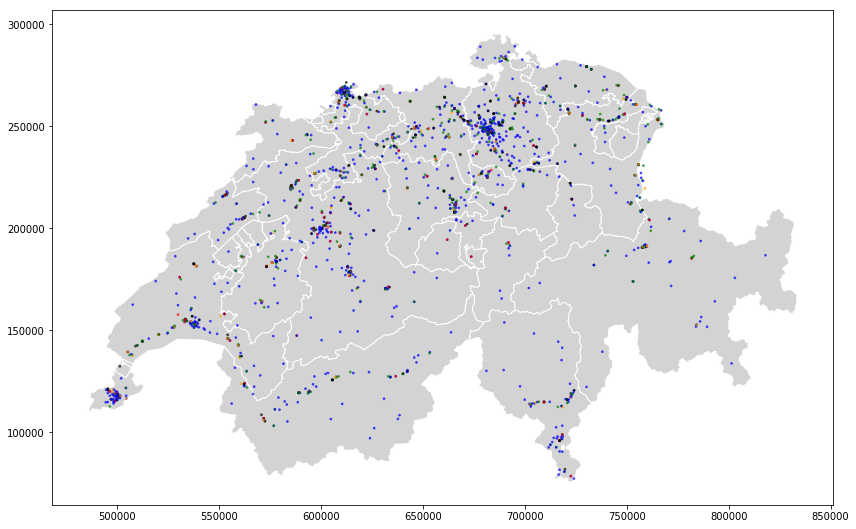

In [42]:
ax = gdf_kantone.plot(figsize=(14,10), color='lightgrey', edgecolor='white')
gdf_stores.plot(markersize=3, ax=ax, color=colorlist, alpha=0.6)

## Geo-Selektion

Was könnten wir nun mit diesen beiden Datensets anfangen, die im selben System kodiert sind (ausser sie zu plotten)?

Zum Beispiel:
- Einzelne Geschäfte selektieren (je nach Kanton)
- Gschäfte pro Kanton zählen

### spatial joins

Ähnlich wie `merge()` in Pandas bietet auch Geopandas eine Funktion an, um zwei Datensets zu kombinieren: `sjoin()`

In [52]:
gdf_merged = gpd.sjoin(gdf_stores, gdf_kantone, how='left', op='within')

/Users/simon/Library/Python/3.6/lib/python/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Wir wählen hier zu jeder Zeile aus dem ersten GDF (gdf_stores, also die Geschäfte) die passende Zeile aus dem anderen GDF (gdf_kantone, also den passenden Kanton) aus.

`how=` gibt wie in pandas an, wie wir matchen wollen:
- "left"
- "right"
- "inner"
- "outer"

`op=` gibt die geometrische matching-methode an:
- "contains" (linke geometrie enthält rechte geometrie)
- "within" (linke geometrie ist innnerhalb rechter geometrie)
- "intersects" (linke geometrie überschneidet sich mit rechter geometrie)

In unserem Fall haben wir also gesagt:
- suche zu jedem store-punkt das passende kantons-polygon
- wobei der punkt innerhalb des polygons liegen muss

Nun haben wir ein zusammengeführtes, ziemlich breites geodataframe:

In [53]:
gdf_merged.columns

Index(['hausnummer', 'latitude', 'longitude', 'name', 'ort', 'plz', 'strasse',
       'typ', 'Punkt', 'index_right', 'KTNR', 'KTNAME', 'GRNR', 'AREA_HA',
       'X_MIN', 'X_MAX', 'Y_MIN', 'Y_MAX', 'X_CNTR', 'Y_CNTR', 'Z_MIN',
       'Z_MAX', 'Z_AVG', 'Z_MED', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX', 'E_CNTR',
       'N_CNTR'],
      dtype='object')

Und das Gute ist: zu jeder Coop-Filiale ist nun die Information enthalten, in welchem Kanton sie liegt.

In [56]:
gdf_merged['KTNAME']

0           Obwalden
1       Bern / Berne
2           Obwalden
3           Obwalden
4           Obwalden
5           Obwalden
6       Bern / Berne
7           Obwalden
8          Nidwalden
9          Nidwalden
10      Bern / Berne
11      Bern / Berne
12         Nidwalden
13         Nidwalden
14         Nidwalden
15         Nidwalden
16            Luzern
17            Luzern
18         Nidwalden
19            Luzern
20            Luzern
21            Luzern
22            Luzern
23            Luzern
24            Luzern
25            Luzern
26            Luzern
27            Luzern
28            Luzern
29            Luzern
            ...     
2045          Genève
2046          Genève
2047          Genève
2048          Genève
2049          Genève
2050          Genève
2051          Genève
2052          Genève
2053          Genève
2054          Genève
2055          Genève
2056          Genève
2057          Genève
2058          Genève
2059          Genève
2060          Genève
2061         

Das ermöglicht uns zB, nur Stores aus einem einzelnen Kanton zu bearbeiten:

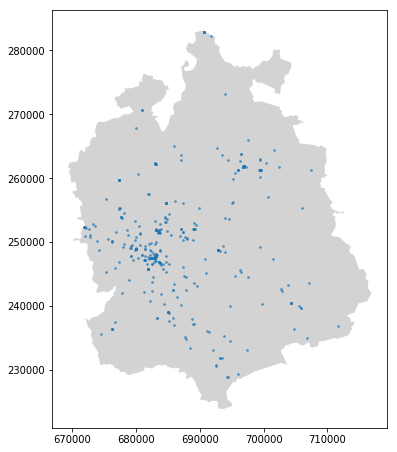

In [65]:
ax = gdf_kantone[gdf_kantone['KTNAME'] == 'Zürich'].plot(color='lightgrey', edgecolor='white', figsize=(6,8))
gdf_merged[gdf_merged['KTNAME'] == 'Zürich'].plot(markersize=3, alpha=0.6, ax=ax)

## Geo-Information darstellen

Wie viele Läden sind in welchem Kanton? Diese Frage können wir nun beantworten:

In [85]:
gdf_merged['KTNAME'].value_counts()

Zürich                              354
Bern / Berne                        295
Vaud                                167
Aargau                              163
St. Gallen                          116
Valais / Wallis                      98
Ticino                               89
Luzern                               85
Genève                               84
Solothurn                            73
Graubünden / Grigioni / Grischun     71
Basel-Landschaft                     71
Basel-Stadt                          71
Thurgau                              69
Fribourg / Freiburg                  64
Neuchâtel                            47
Zug                                  34
Schwyz                               33
Jura                                 21
Schaffhausen                         20
Glarus                               12
Uri                                  10
Nidwalden                             7
Obwalden                              6
Appenzell Ausserrhoden                5


Um diese Information wiederum geografisch darzustellen, können wir sie zurück in unser Kantone-GDF mergen.

**Vorbereitung:**

In [68]:
df_anzahl = gdf_merged['KTNAME'].value_counts().to_frame()

In [73]:
df_anzahl = df_anzahl.rename(columns={'KTNAME': 'Anzahl'})

In [74]:
df_anzahl.head(5)

,Anzahl
Zürich,354
Bern / Berne,295
Vaud,167
Aargau,163
St. Gallen,116


**Merge:**

In [76]:
gdf_kantone_anzahl = gdf_kantone.merge(df_anzahl, how='inner', left_on='KTNAME', right_index=True)

In [77]:
gdf_kantone_anzahl.head(2)

,KTNR,KTNAME,GRNR,AREA_HA,X_MIN,X_MAX,Y_MIN,Y_MAX,X_CNTR,Y_CNTR,...,Z_AVG,Z_MED,E_MIN,E_MAX,N_MIN,N_MAX,E_CNTR,N_CNTR,geometry,Anzahl
0,1,Zürich,4,172894,669244,716900,223896,283343,691800,252000,...,533,504,2669244,2716900,1223896,1283343,2691800,1252000,"POLYGON ((692429.2019999996 281173.7069999985,...",354
1,2,Bern / Berne,2,595952,556241,677745,130585,243834,614200,185600,...,1198,979,2556241,2677745,1130585,1243834,2614200,1185600,(POLYGON ((573502.2039999999 194804.7199999988...,295


**Plot:**

Siehe auch: http://geopandas.org/mapping.html

Wir können Geopandas in der `plot()`-Funktion angeben, wie die Farbcodierung erstellt werden soll.

- `column=` - welche Spalte verwendet werden soll: in unserem Fall, "Anzahl"
- `cmap=` - welche Colormap werwendet werden soll: https://matplotlib.org/examples/color/colormaps_reference.html
- `scheme=` - kann "equal_interval" oder "quantiles" sein. Standardzahl der Schritte ist 5.

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Anzahl Coop-Filialen pro Kanton')

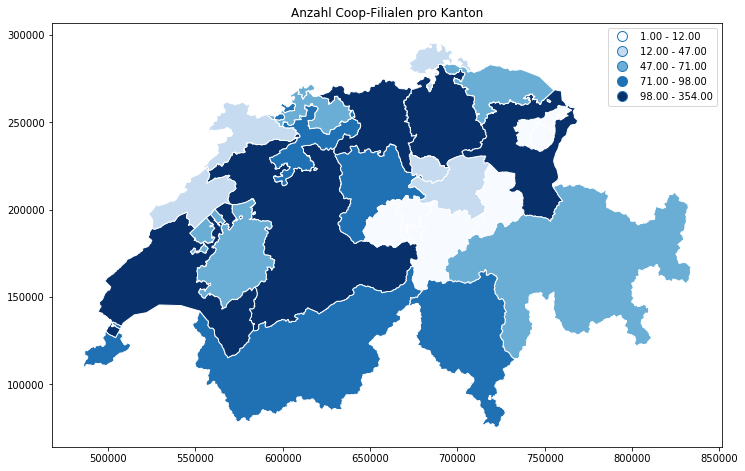

In [82]:
ax = gdf_kantone_anzahl.plot(column='Anzahl', cmap='Blues', scheme='quantiles', edgecolor='white', legend=True, figsize=(12,12))
ax.set_title('Anzahl Coop-Filialen pro Kanton')